In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import OrderedDict
from torch import Tensor
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
import glob
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset,DataLoader
import torchvision.transforms as transforms
import torchvision
import random
from google.colab import files
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import ShuffleSplit
import cv2
from google.colab.patches import cv2_imshow
from scipy.ndimage import distance_transform_edt
from torch.autograd import Variable
import skimage.segmentation
import skimage.io
import skimage 
from scipy.optimize import linear_sum_assignment
import skimage.segmentation
import matplotlib.pyplot as plt
import skimage.io
import skimage.segmentation
from skimage import feature
from skimage import filters
import copy
import torchvision
from collections import OrderedDict
import math
from tqdm import tqdm
import imageio

In [ ]:
def randomHueSaturationValue(
    image,
    hue_shift_limit=(-40, 40),
    sat_shift_limit=(-10, 10),
    val_shift_limit=(-20, 20),
    u=0.5,
):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.randint(
            hue_shift_limit[0], hue_shift_limit[1] + 1)
        hue_shift = np.uint8(hue_shift)
        h += hue_shift
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
 
    return image
 
 
def randomShiftScaleRotate(
    image,
    mask,
    shift_limit=(-0.1, 0.1),
    scale_limit=(-0.1, 0.1),
    aspect_limit=(-0.1, 0.1),
    rotate_limit=(-90, 90),
    borderMode=cv2.BORDER_CONSTANT,
    u=0.5,
):
    if np.random.random() < u:
        height, width, channel = image.shape
 
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)
 
        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])
 
        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height]])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array(
            [width / 2 + dx, height / 2 + dy]
        )
 
        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(
            image,
            mat,
            (width, height),
            flags=cv2.INTER_NEAREST,
            borderMode=borderMode,
            borderValue=(0, 0, 0),
        )
        mask = cv2.warpPerspective(
            mask,
            mat,
            (width, height),
            flags=cv2.INTER_NEAREST,
            borderMode=borderMode,
            borderValue=(0, 0, 0),
        )
 
    return image, mask
 
 
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
 
    return image, mask
 
 
def randomVerticleFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)
 
    return image, mask
 
 
def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        image = np.rot90(image)
        mask = np.rot90(mask)
 
    return image, mask

In [ ]:
def my_func(e):
  return len(e) 

In [ ]:
files_list=os.listdir('/content/drive/MyDrive/MRI_Dataset')
files_list.sort()
files_list=['/content/drive/MyDrive/MRI_Dataset/'+i for i in files_list]
#folds--->
# example fold
train_files,test_files=train_test_split(np.array(files_list),test_size=0.2,random_state=18928343)

In [ ]:
train_image_list=[]
train_mask_list=[]
for i in range(88):
  images=glob.glob(train_files[i]+'*/**.tif')
  images=[i for i in images if 'mask' not in i ]
  images.sort()
  images.sort(key=my_func)
  mask=glob.glob(train_files[i]+'*/**mask*.tif')
  mask.sort()
  mask.sort(key=my_func)
  train_image_list.extend(images)
  train_mask_list.extend(mask)

test_image_list=[]
test_mask_list=[]
for i in range(22):
  images_test=glob.glob(test_files[i]+'*/**.tif')
  images_test=[i for i in images_test if 'mask' not in i ]
  images_test.sort()
  images_test.sort(key=my_func)
  mask_test=glob.glob(test_files[i]+'*/**mask*.tif')
  mask_test.sort()
  mask_test.sort(key=my_func)
  test_image_list.extend(images_test)
  test_mask_list.extend(mask_test)  

In [ ]:
image=cv2.imread(test_image_list[15])

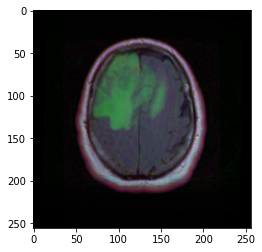

In [ ]:
plt.imshow(image)

In [ ]:
class data_train(Dataset):
  def __init__(self,train_image_list,train_mask_list):
    self.image_path=train_image_list
    self.labels=train_mask_list
 
  def __len__(self):
    return len(self.image_path)
  def __getitem__(self, idx):
    image=imageio.imread(self.image_path[idx])
    mask=cv2.imread(self.labels[idx])  
    #augment_functions
    a=image[:,:,0:3].astype('uint8')
    a=randomHueSaturationValue(a)
    image[:,:,0:3]=a
    image,mask=randomShiftScaleRotate(image,mask)
    image,mask=randomVerticleFlip(image,mask)
    image,mask=randomHorizontalFlip(image,mask)
    image,mask=randomRotate90(image,mask)

    image=torch.from_numpy(image/255.0).permute(2,0,1)
    mask=torch.from_numpy(mask/255.0).permute(2,0,1)
    return image, mask[0:1,:,:] 
 
    
train_ds=data_train(train_image_list,train_mask_list)

In [ ]:
class data_test(Dataset):
  def __init__(self,test_image_list,test_mask_list):
    self.image_path=test_image_list
    self.labels=test_mask_list
 
  def __len__(self):
    return len(self.image_path)
  def __getitem__(self, idx):
    image=imageio.imread(self.image_path[idx])
    mask=cv2.imread(self.labels[idx])  
 
    image=torch.from_numpy(image/255.0).permute(2,0,1)
    mask=torch.from_numpy(mask/255.0).permute(2,0,1)
    return image, mask[0:1,:,:] 
 
    
test_ds=data_test(test_image_list,test_mask_list)

In [ ]:
train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=4)
test_dl=DataLoader(test_ds,batch_size=60,num_workers=4)

In [ ]:
#new covidnet

class Upsample(nn.Module):
    """ nn.Upsample is deprecated """
 
    def __init__(self, scale_factor, mode="bilinear"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
 
    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=True, recompute_scale_factor=True)
        return x    
        
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
 
 
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
 
 
class BasicBlock(nn.Module):
    expansion: int = 1
 
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = True,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')

        self.conv1 = conv3x3(inplanes, planes, stride,dilation=dilation)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,stride=1,dilation=dilation)
        self.bn2 = norm_layer(planes)
        if downsample == True:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        elif isinstance(downsample, nn.Module):
            self.downsample = downsample
        else:
            self.downsample = None
        self.stride = stride
 
    def forward(self, x: Tensor) -> Tensor:
        identity = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            identity = self.downsample(identity)
 
        out += identity
        out = self.relu(out)
 
        return out
 
 
class BasicBlock_2(nn.Module):
    expansion: int = 1
 
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock_2, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x: Tensor) -> Tensor:
 
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        
        out = self.relu(out)
 
        return out
 
 
class ResNet(nn.Module):
 
    def __init__(
        self,
        initial_channel: int, 
        block: Type[Union[BasicBlock, BasicBlock_2]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
 
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:

            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(initial_channel, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
 
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1,
                                       dilate=False,dilation=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                       dilate=False,dilation=4)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                       dilate=False,dilation=8)
 
        self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxpool3=nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxpool4=nn.MaxPool2d(kernel_size=2,stride=2)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
 
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
 
    def _make_layer(self, block: Type[Union[BasicBlock, BasicBlock_2]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False,dilation: int = 1) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,stride=1,groups=self.groups,
                                base_width=self.base_width,dilation=dilation,
                                norm_layer=norm_layer))
 
        return nn.Sequential(*layers)
 
    def forward(self, x): 
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x1 = self.layer1(x)
        x2 = self.layer2(self.maxpool1(x1))
        x3 = self.layer3(self.maxpool2(x2))
        x4 = self.layer4(self.maxpool3(x3))
        x5 = self.maxpool4(x4)
 
        return x1,x2,x3,x4,x5

 
class bn_conv(nn.Module):
    def __init__(self,num_init_features,output_channels,dilation=1):
        super(bn_conv,self).__init__()
        self.features = nn.Sequential(OrderedDict([ 
            ('conv0', nn.Conv2d(num_init_features,output_channels,kernel_size=3, stride=1,
                                padding=dilation, bias=False,dilation=dilation)), 
            ('norm0', nn.BatchNorm2d(output_channels)),
            ('relu0', nn.ReLU(inplace=True))          
    
        ]))
    def forward(self,x):
        x=self.features(x)
        return x

class bn_conv2(nn.Module):
    def __init__(self, initial_channels,output_channels,dilation=1):
        super(bn_conv2,self).__init__()
        self.conv1=bn_conv(initial_channels,output_channels,dilation)
        self.conv2=bn_conv(output_channels,output_channels,dilation)
    def forward(self, x):
        x=self.conv1(x)
        x=self.conv2(x)
        return x 

class up_conv(nn.Module):
    def __init__(self,initial_channels,output_channels,dilation):
        super(up_conv,self).__init__()
        self.upsample=Upsample(2)
        self.conv=bn_conv(initial_channels,output_channels,dilation)
    def forward(self,x):
        x=self.conv(self.upsample(x))
        return x

class conv_11(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(conv_11,self).__init__()
        self.conv=nn.Conv2d(input_channels,output_channels,kernel_size=1,stride=1)
    def forward(self,x):
        x=self.conv(x)
        return x
        
class decoder(nn.Module):
    def __init__(self,input_channels,upsample_factor,dilation):
        super(decoder,self).__init__()
        self.conv1=bn_conv(input_channels,input_channels//2,dilation)
        self.conv2=bn_conv(input_channels//2,input_channels//4,dilation)

        #Multi-Scale-Supervision-Block  
        self.conv3=nn.Conv2d(input_channels//4,64,kernel_size=3,stride=1,padding=1)
        self.conv4=conv_11(64,1)
        self.upsample=Upsample(upsample_factor)
        #End Multi-Scale_Supervision-Block
    def forward(self,x):
        x=self.conv1(x)
        x1=self.conv2(x)
        #Use of Multi-Scale-Supervision-Block 
        x2=self.conv3(x1)    
        x2=self.conv4(self.upsample(x2))
        return x1,x2

class final_decoder(nn.Module):
    def __init__(self,input_channels,dilation):
        super(final_decoder,self).__init__()
        self.conv1=bn_conv(input_channels,input_channels//2,dilation)
        self.conv2=nn.Conv2d(input_channels//2,64,kernel_size=3,stride=1,padding=1)
        self.conv3=conv_11(64,1)

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        return x


class D3MSU(nn.Module):
    def __init__(self,input_channels):
        super(D3MSU,self).__init__()
        self.encoder=ResNet(input_channels,BasicBlock,[3,3,3,3])
        self.bn_conv0=bn_conv2(512,512,8)

        self.decoder1=decoder(1024,8,8)
        self.decoder2=decoder(512,4,4)
        self.decoder3=decoder(256,2,2)
        self.decoder4=final_decoder(128,1)

        self.upconv1=nn.ConvTranspose2d(512,512,kernel_size=2,stride=2)
        self.upconv2=nn.ConvTranspose2d(256,256,kernel_size=2,stride=2)
        self.upconv3=nn.ConvTranspose2d(128,128,kernel_size=2,stride=2)
        self.upconv4=nn.ConvTranspose2d(64,64,kernel_size=2,stride=2)


    def forward(self,x):
        
        x1,x2,x3,x4,x5=self.encoder(x)
        
        x5=self.bn_conv0(x5)        

        x5=self.upconv1(x5)
        x_4,x_out4=self.decoder1(torch.cat((x5,x4),1))

        x_4=self.upconv2(x_4)
        x_3,x_out3=self.decoder2(torch.cat((x_4,x3),1))

        x_3=self.upconv3(x_3)
        x_2,x_out2=self.decoder3(torch.cat((x_3,x2),1))

        x_2=self.upconv4(x_2)
        x_out1=self.decoder4(torch.cat((x_2,x1),1))
        
        
        return torch.sigmoid(x_out1), torch.sigmoid(x_out2), torch.sigmoid(x_out3), torch.sigmoid(x_out4)
  


In [ ]:
model=D3MSU(3)
model=model.to('cuda:0')

In [ ]:
#loss function
class dice_bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()
 
    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 1.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        return score.mean()
 
    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss
 
    def __call__(self, y_pred, y_true):
        a = self.bce_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        return a + b

In [ ]:
class IoU(nn.Module):
    def __init__(self, threshold=0.5):
        super(IoU, self).__init__()
        self.threshold = threshold
 
    def forward(self, target, input):
        eps = 1e-10
        input_ = (input > self.threshold).data.float()
        target_ = (target > self.threshold).data.float()
 
        intersection = torch.clamp(input_ * target_, 0, 1)
        union = torch.clamp(input_ + target_, 0, 1)
 
        if torch.mean(intersection).lt(eps):
            return torch.Tensor([0., 0., 0., 0.])
        else:
            acc = torch.mean((input_ == target_).data.float())
            iou = torch.mean(intersection) / torch.mean(union)
            recall = torch.mean(intersection) / torch.mean(target_)
            precision = torch.mean(intersection) / torch.mean(input_)
            return torch.Tensor([acc, recall, precision, iou])
iou=IoU()

In [ ]:
def multiscale_loss(prediction1,prediction2,prediction3,prediction4,label):
    dice_loss=dice_bce_loss()
    loss1=dice_loss(prediction1,label)
    loss2=dice_loss(prediction2,label)
    loss3=dice_loss(prediction3,label)
    loss4=dice_loss(prediction4,label)
    loss=loss1+loss2+loss3+loss4
    return loss

In [ ]:
def dice_coeff(y_true,y_pred,batch=True):
        smooth = 1e-8  # may change
        y_true=y_true.float()
        y_pred=(y_pred>0.5)*1.0
        if batch:
            i = torch.sum(y_true*1.0)
            j = torch.sum(y_pred*1.0)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = (y_true**1).sum(1).sum(1).sum(1)
            j = (y_pred**1).sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        return score.mean()

In [ ]:
def train_one_epoch_d3msunet(model, train_dl, learn):
    opt = torch.optim.Adam(model.parameters(),lr=learn)
    running_loss_image=0.0
    metric_epoch=0.0
    dice_epoch=0.0
    for a,b in train_dl:
        a=a.float()
        label=b.float()        
        pred1,pred2,pred3,pred4=model(a.cuda())
        loss=multiscale_loss(pred1,pred2,pred3,pred4,label.cuda())
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss_image += loss
        metric=iou(label.cuda(),pred1)
        dice = dice_coeff(label.cuda(),pred1)
        dice_epoch += dice 
        metric_epoch += metric
    running_loss_image/=len(train_dl)
    metric_epoch /= len(train_dl)
    dice_epoch /= len(train_dl)
    return model, metric_epoch, dice_epoch, running_loss_image
 

def validate_one_epoch_d3msunet(model, val_dl):
    running_loss_image=0.0
    metric_epoch=0.0
    dice_epoch=0.0   
    with torch.no_grad():
        for a,b in val_dl:
            a=a.float()
            label=b.float()
            pred1,pred2,pred3,pred4=model(a.cuda())
            loss=multiscale_loss(pred1,pred2,pred3,pred4,label.cuda())
            running_loss_image += loss
            metric=iou(label.cuda(),pred1)
            dice = dice_coeff(label.cuda(),pred1)
            dice_epoch += dice 
            metric_epoch += metric  
    running_loss_image/=len(val_dl)
    metric_epoch /= len(val_dl)
    dice_epoch /= len(val_dl)
    return metric_epoch, dice_epoch, running_loss_image

In [ ]:
def train_epoches_d3msunet(model,train_dl,test_dl,epoches,learn,path):
    max_accuracy=0.0
    path_max=''
    for i in range(epoches):
        model,metric_train,dice_train,loss_train=train_one_epoch_d3msunet(model,train_dl,learn)
        metric_test,dice_test,loss_test=validate_one_epoch_d3msunet(model,test_dl)
        print('epoch finished' +" " + str(i+1) + "  " + "learning_rate = "+ str(learn))
        print(f'train_loss: {loss_train:.6f}  metric_train:{metric_train} dice_train:{dice_train}')
        print(f'test_loss: {loss_test:.6f} metric_test:{metric_test} dice_test:{dice_test}')
        print()
        if metric_test[3]>max_accuracy:
            max_accuracy=metric_test[3]
            path_final=os.path.join(path,
                                    f"epoch{i}_test_iou{metric_test[3]:.4f}_dice{dice_test:.4f}.pth")
            torch.save(model.state_dict(), path_final)  
            path_max=path_final
    return path_max            